# Porto Seguro’s Safe Driver Prediction

## Simple kernel

### Import libs

In [18]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from scipy.sparse import csr_matrix

### Define gini func

In [19]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

### Load files

In [20]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [21]:
df_train.head().T

,0,1,2,3,4
id,7.000000,9.000000,13.000000,16.000000,17.000000
target,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_01,2.000000,1.000000,5.000000,0.000000,0.000000
ps_ind_02_cat,2.000000,1.000000,4.000000,1.000000,2.000000
ps_ind_03,5.000000,7.000000,9.000000,2.000000,0.000000
ps_ind_04_cat,1.000000,0.000000,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_07_bin,1.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000,0.000000,0.000000


In [22]:
df_train.shape, df_test.shape

((595212, 59), (892816, 58))

### View target dist

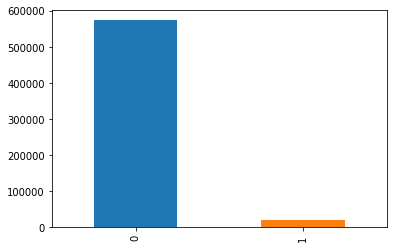

In [23]:
df_train['target'].value_counts().plot(kind='bar')

In [24]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### Drop calculated features

In [25]:
col_to_drop = df_train.columns[df_train.columns.str.startswith('ps_calc_')]
df_train.drop(col_to_drop, axis=1, inplace=True)  
df_test.drop(col_to_drop, axis=1, inplace=True) 

cat_features = [a for a in df_train.columns if a.endswith('cat')]

### Some combinations from other kernels

In [26]:
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat')
]

combs_features = [
#     'ps_car_13_mul_ps_reg_03'
]
for df in [df_train, df_test]:
#     df['ps_car_13_mul_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    for cmb in combs:
        k = '_plus_'.join(cmb)
        df[k] = df[cmb[0]].astype(str) + '_' + df[cmb[1]].astype(str)
        if k not in combs_features:
            combs_features.append(k)

### OHE

In [27]:
df_train = pd.get_dummies(df_train, columns=cat_features+combs_features)
df_test = pd.get_dummies(df_test, columns=cat_features+combs_features)

In [28]:
df_train.values.shape, df_test.values.shape

((595212, 333), (892816, 332))

### Preparing data for model

In [29]:
y = df_train['target'].values

df_train.drop(['id', 'target'], inplace=True, axis=1)
df_test.drop(['id'], inplace=True, axis=1)

X = csr_matrix(df_train.values)

X_test = csr_matrix(df_test.values)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

### Define model (RF)

In [30]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_valid)[:, 1]

gini = eval_gini(y_valid, y_pred)
print('Gini: ', gini)

Gini:  0.0710932518939


### Define model (logreg)

In [31]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_valid)[:, 1]

gini = eval_gini(y_valid, y_pred)
print('Gini: ', gini)

Gini:  0.251923506312


### Define model (xgboost)

In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_valid)[:, 1]

gini = eval_gini(y_valid, y_pred)
print('Gini: ', gini)

Gini:  0.267133772241


### Make submission

In [33]:
y_test = model.predict_proba(X_test)[:, 1]
sdf = pd.read_csv('data/sample_submission.csv')
sdf['target'] = y_test
sdf.to_csv('submission.csv', index=False)

In [34]:
!head submission.csv

id,target
0,0.023419110104441643
1,0.026012003421783447
2,0.03098887763917446
3,0.016708165407180786
4,0.036174457520246506
5,0.03991100564599037
6,0.01805737242102623
8,0.035276442766189575
10,0.04859273508191109


### TODO
- visual analysis (correlations)
- t-SNE
- PCA
- GridSearch (RandomSearch)
- more combinations (LabelBinarizer?)
- scaler for specific features
- missing values processing